# 2D Preprocessing example
Notebook used to preprocess DESI Spectra into 2D images and dump them into pickeld files. 

In [1]:
from desispec.io import read_spectra
from desispec.interpolation import resample_flux
import desispec.io
from desispec.resolution import Resolution
from desispec.spectra import Spectra
from desispec.coaddition import coadd_cameras
from desispec.spectra import stack as specstack

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table, hstack, join, vstack

import copy
import os
import pickle
import platform
from desiutil.log import get_logger

 Couldn't install DESITRIP package on NERSC hence rescale and rebin code written below

In [2]:
def rescale_flux(flux):
    """Rescale flux so that it ranges from 0 to 1.
    Parameters
    ----------
    flux : ndarray
        Input flux array.
    Returns
    -------
    rsfl : ndarray
        Flux rescaled to range between 0 and 1.
    """

    if flux.ndim > 1:
        a, b = np.min(flux,axis=1)[:,None], np.max(flux,axis=1)[:,None]
    else:
        a, b = np.min(flux), np.max(flux)
    
    return (flux - a) / (b - a)

In [3]:
def rebin_flux(wave, flux, ivar=None, z=None, minwave=3600., maxwave=9800., nbins=1, log=False, clip=False):
    """Rebin differential flux vs wavelength using desispec resample_flux.
    Parameters
    ----------
    wave : ndarray
        Input wavelength; assume units of Angstroms.
    flux : ndarray
        Input differential spectra as a function of wavelength.
    ivar : None or ndarray
        Inverse variance (weight) of spectra vs wavelength.
    z : None, float, or ndarray
        Known or estimated redshift(s) for input spectra.
    minwave : float
        Minimum output wavelength, in units of Angstroms.
    maxwave : float
        Maximum output wavelength, in units of Angstroms.
    nbins : int
        Number of output wavelength bins.
    log : bool
        If true, use logarithmic bins between minwave and maxwave.
    clip : bool
        If true, clip input values below zero before rescaling.
    Returns
    -------
    basewave : ndarray
        Output wavelength, in units of Angstroms.
    fl : ndarray
        Rebinned spectra.
    iv : ndarray
        Rebinned inverse variance.
    """
    # Choose new binning.
    if log:
        basewave = np.logspace(np.log10(minwave), np.log10(maxwave), nbins)
    else:
        basewave = np.linspace(minwave, maxwave, nbins)

    # Shift to rest frame.
    if z is not None:
        wave = wave/(1+z) if np.isscalar(z) else np.outer(1./(1+z), wave)

    if flux.ndim > 1:
        # Remove spectra with NaNs and zero flux values.
        mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
        mask_idx = np.argwhere(mask)
        flux = np.delete(flux, mask_idx, axis=0)
        ivar = np.delete(ivar, mask_idx, axis=0)
        if wave.ndim > 1:
            wave = np.delete(wave, mask_idx, axis=0)

        nspec = len(flux)
        fl = np.zeros((nspec, nbins))
        iv = np.ones((nspec, nbins))
        for i in range(nspec):
            # Wavelength array may be different for each input flux, e.g., if
            # we shift to the rest frame.
            wave_ = wave[i] if wave.ndim > 1 else wave

            if ivar is not None:
                fl[i], iv[i] = resample_flux(basewave, wave_, flux[i], ivar[i])
            else:
                fl[i] = resample_flux(basewave, wave_, flux[i])
    else:
        resampled = resample_flux(basewave, wave, flux, ivar)
        if ivar is not None:
            fl, iv = resampled
        else:
            fl, iv = resampled, None

    # Enable clipping of negative values.
    if clip:
        fl = fl.clip(min=0)
    return basewave, fl, iv

In [4]:
def condition_spectra(coadd_files, truth_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        truth = Table.read(tf, 'TRUTH')
        truez = truth['TRUEZ']

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        #rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=3600., maxwave=9800., nbins=3600, log=False, clip=True)
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, minwave=3600., maxwave=9800., nbins=3600, log=False, clip=True, z=None)
        rsflux = rescale_flux(reflux)
        
        

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    
    #,rewave,reflux,wave,flux,ivar
    return fluxes

In [5]:
def to_2d(flux):
    
    return_flux=[]
    for i in range(len(flux)):
        trial=flux[i][0:6421]
        trial=((trial-np.min(trial))/(np.max(trial) - np.min(trial)))
        trial=trial.reshape(60,60)
        return_flux.append(trial)
        
    bad_host_counter=0
    final_flux=[]
    for i in return_flux:
        if np.sum(i)==0 or np.isnan(np.sum(i)):
            bad_host_counter=bad_host_counter+1
        else:
            final_flux.append(i)
    
    return final_flux

## Open Co-added Simulation of Lens+Source

### Convert to 2D Spectra without Redshift

## Simulated Single Spectra

In [6]:
# Read in the file created using a function call to desispec_coadd --coadd-cameras
coadd_file = os.path.join(os.getcwd(), '/global/project/projectdirs/desi/science/gqp/stronglens/Sim_SpecLens/Single/coaddcam-single-chunk001.fits')
coadd = desispec.io.read_spectra(coadd_file)

# Read in the same chunk redshift data to get the ZBEST table and stuff it into the extra_catalog of the Spectra object.
# 1) Code below will access the true redshifts.
truth=os.path.join(os.getcwd(), '/global/project/projectdirs/desi/science/gqp/stronglens/Sim_SpecLens/Single/lenssource-truth.fits')
meta = Table.read(truth, 'METADATA')
idxm = np.searchsorted(meta['TARGETID'], coadd.fibermap['TARGETID'])
coadd.extra_catalog = meta[idxm]

# 2) Code below will access the redshift best fit.
#zbest = Table.read('single-chunk001.fits', 'ZBEST')
zbest = Table.read(coadd_file)
idxz = np.searchsorted(zbest['TARGETID'], coadd.fibermap['TARGETID'])

# Mash the redshift truth table into the redshift best-fit table.
# Now we can use to check how close the best-fit redshift is matching the lens' true redshift.
coadd.extra_catalog = join(meta[idxm], zbest[idxz])

INFO:spectra.py:282:read_spectra: iotime 16.788 sec to read coaddcam-single-chunk001.fits at 2021-08-13T08:22:49.621960


In [11]:
# Take all the fluxes in the coadd spectra and rebin to a common wavelength grid.
# Note that this does not de-redshift the spectra!
rb_wave, rb_flux, rb_ivar = rebin_flux(coadd.wave['brz'], coadd.flux['brz'], coadd.ivar['brz'], nbins=3600)

In [12]:
# Convert all the fluxes after rebinning to a 60x60 image.
flux_2d = to_2d(rb_flux)

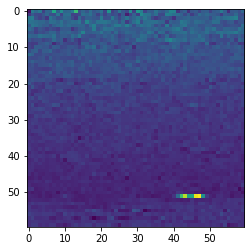

In [13]:
# Plot one of the fluxes.
plt.imshow(flux_2d[6])

In [14]:
# Try dumping to a file.
with open(r'chunkall-single.data', 'wb') as f:
    pickle.dump(flux_2d, f) 

## Simulated Lense Spectra

In [ ]:
# Read in the file created using a function call to desispec_coadd --coadd-cameras
coadd_file = os.path.join(os.getcwd(), '/global/project/projectdirs/desi/science/gqp/stronglens/Sim_SpecLens/Lense/chunkall-lenssource.fits')
coadd = desispec.io.read_spectra(coadd_file)

# Read in the same chunk redshift data to get the ZBEST table and stuff it into the extra_catalog of the Spectra object.
# 1) Code below will access the true redshifts.
truth=os.path.join(os.getcwd(), '/global/project/projectdirs/desi/science/gqp/stronglens/Sim_SpecLens/Lense/lenssource-truth.fits')
meta = Table.read(truth, 'METADATA')
idxm = np.searchsorted(meta['TARGETID'], coadd.fibermap['TARGETID'])
coadd.extra_catalog = meta[idxm]

# 2) Code below will access the redshift best fit.
#zbest = Table.read('single-chunk001.fits', 'ZBEST')
zbest = Table.read(coadd_file)
idxz = np.searchsorted(zbest['TARGETID'], coadd.fibermap['TARGETID'])

# Mash the redshift truth table into the redshift best-fit table.
# Now we can use to check how close the best-fit redshift is matching the lens' true redshift.
coadd.extra_catalog = join(meta[idxm], zbest[idxz])

plt.plot(coadd.wave['brz'], coadd.flux['brz'][3], coadd.ivar['brz'])

## Tile Data from 2021/07/08

In [6]:
redux = 'daily/tiles/cumulative'
basedir = os.environ['DESI_SPECTRO_REDUX']

tiles = ['80980', '80981']
date = '20210708'

too_targets = None

for tile in tiles:
    tilefolder = '{}/{}/{}/{}'.format(basedir, redux, tile, date)
    zbest_files = sorted(glob('{}/zbest*fits'.format(tilefolder)))
    for zbest_file in zbest_files:
        # Read the redshift fit.
        zbest = Table.read(zbest_file, 'ZBEST')
           
        # Grab the spectra from the corresponding coadd file.
        coadd_file = zbest_file.replace('zbest', 'coadd')
        coadd = read_spectra(coadd_file)
        
        # Join the fibermap and zbest tables.
        targets = join(coadd.fibermap, zbest, keys=['TARGETID'])
        select = (targets['SPECTYPE'] == 'GALAXY') & (targets['ZWARN'] == 0) & (targets['DELTACHI2'] >= 25.)
        idx = np.where(select)
        
        
        print(np.sum(select))
        
        if too_targets is None:
            too_targets = coadd[idx]
        else:
            too_targets = specstack([too_targets, coadd[idx]])

INFO:spectra.py:282:read_spectra: iotime 1.323 sec to read coadd-0-80980-thru20210708.fits at 2021-08-11T21:00:59.315004
254
INFO:spectra.py:282:read_spectra: iotime 1.010 sec to read coadd-1-80980-thru20210708.fits at 2021-08-11T21:01:01.441521
206
INFO:spectra.py:282:read_spectra: iotime 0.843 sec to read coadd-2-80980-thru20210708.fits at 2021-08-11T21:01:03.885491
177
INFO:spectra.py:282:read_spectra: iotime 0.880 sec to read coadd-3-80980-thru20210708.fits at 2021-08-11T21:01:06.400206
186
INFO:spectra.py:282:read_spectra: iotime 0.762 sec to read coadd-4-80980-thru20210708.fits at 2021-08-11T21:01:09.217127
195
INFO:spectra.py:282:read_spectra: iotime 0.963 sec to read coadd-5-80980-thru20210708.fits at 2021-08-11T21:01:12.592688
210
INFO:spectra.py:282:read_spectra: iotime 0.988 sec to read coadd-6-80980-thru20210708.fits at 2021-08-11T21:01:17.945987
125
INFO:spectra.py:282:read_spectra: iotime 1.305 sec to read coadd-7-80980-thru20210708.fits at 2021-08-11T21:01:22.694732
107


In [7]:
coadd_targets = coadd_cameras(too_targets)

In [8]:
coadd_targets.num_spectra()

3308

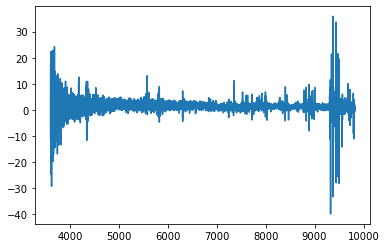

In [9]:
i = np.random.choice(coadd_targets.num_spectra())
plt.plot(coadd_targets.wave['brz'], coadd_targets.flux['brz'][i])

In [10]:
coadd=coadd_targets
rb_wave, rb_flux, rb_ivar = rebin_flux(coadd.wave['brz'], coadd.flux['brz'], coadd.ivar['brz'], nbins=3600)

In [11]:
flux_2d = to_2d(rb_flux)
ivar_2d=to_2d(rb_ivar)

In [12]:
with open(r'too_20210708.data', 'wb') as f:
    pickle.dump(flux_2d, f) 
with open(r'too_20210708_ivar.data', 'wb') as f:
    pickle.dump(ivar_2d, f) 

## Synthlens Synthetic Strong Lens Generator Lens Spectra

In [6]:
fitfile=[
    'tile000001',
    'tile000002',
    'tile000012',
    'tile000013',
    'tile000014',
    'tile000015',
    'tile000016',
    'tile000017',
    'tile000018',
    'tile000019',
    'tile000020',
    'tile000021',
    'tile000028',
    'tile000029',
    'tile000030',
    'tile000039',
    'tile000040',
    'tile000041',
    'tile000042'
]

In [8]:
import pickle
for tile in range(len(fitfile)):
    coadd_file=os.path.join(os.getcwd(), '/global/project/projectdirs/desi/science/gqp/stronglens/training/everest/{}_sgl_coadd.fits'.format(fitfile[tile]))
    coadd = desispec.io.read_spectra(coadd_file)
    if coadd.flux !=0:
        rb_wave, rb_flux, rb_ivar = rebin_flux(coadd.wave['brz'], coadd.flux['brz'], coadd.ivar['brz'], nbins=3600)
        flux_2d=to_2d(rb_flux)
        ivar_2d=to_2d(rb_ivar)
        with open(r'single_spectra{}.data'.format(tile), 'wb') as f:
            pickle.dump(flux_2d, f) 
        with open(r'single_spectra{}_ivar.data'.format(tile), 'wb') as f:
            pickle.dump(ivar_2d, f) 

INFO:spectra.py:282:read_spectra: iotime 2.691 sec to read tile000001_sgl_coadd.fits at 2021-08-17T10:07:53.712006
INFO:spectra.py:282:read_spectra: iotime 2.807 sec to read tile000002_sgl_coadd.fits at 2021-08-17T10:08:06.684933
INFO:spectra.py:282:read_spectra: iotime 3.295 sec to read tile000012_sgl_coadd.fits at 2021-08-17T10:08:20.731579
INFO:spectra.py:282:read_spectra: iotime 2.421 sec to read tile000013_sgl_coadd.fits at 2021-08-17T10:08:35.238858
INFO:spectra.py:282:read_spectra: iotime 2.145 sec to read tile000014_sgl_coadd.fits at 2021-08-17T10:08:46.745539
INFO:spectra.py:282:read_spectra: iotime 1.653 sec to read tile000015_sgl_coadd.fits at 2021-08-17T10:08:55.761240
INFO:spectra.py:282:read_spectra: iotime 1.280 sec to read tile000016_sgl_coadd.fits at 2021-08-17T10:09:02.703742
INFO:spectra.py:282:read_spectra: iotime 1.712 sec to read tile000017_sgl_coadd.fits at 2021-08-17T10:09:08.289769
INFO:spectra.py:282:read_spectra: iotime 1.686 sec to read tile000018_sgl_coadd.

In [48]:
for tile in range(len(fitfile)):
    coadd_file=os.path.join(os.getcwd(), '/global/project/projectdirs/desi/science/gqp/stronglens/training/everest/{}_simlens_coadd.fits'.format(fitfile[tile]))
    coadd = desispec.io.read_spectra(coadd_file)
    if coadd.flux !=0:
        rb_wave, rb_flux, rb_ivar = rebin_flux(coadd.wave['brz'], coadd.flux['brz'], coadd.ivar['brz'], nbins=3600)
        flux_2d=to_2d(rb_flux)
        ivar_2d=to_2d(rb_ivar)
        with open(r'lens_spectra{}.data'.format(tile), 'wb') as f:
            pickle.dump(flux_2d, f) 
        with open(r'lens_spectra{}_ivar.data'.format(tile), 'wb') as f:
            pickle.dump(ivar_2d, f) 

INFO:spectra.py:282:read_spectra: iotime 0.803 sec to read tile000001_simlens_coadd.fits at 2021-08-17T11:04:59.994253
INFO:spectra.py:282:read_spectra: iotime 0.887 sec to read tile000002_simlens_coadd.fits at 2021-08-17T11:05:03.217939
INFO:spectra.py:282:read_spectra: iotime 0.685 sec to read tile000012_simlens_coadd.fits at 2021-08-17T11:05:06.303524
INFO:spectra.py:282:read_spectra: iotime 0.799 sec to read tile000013_simlens_coadd.fits at 2021-08-17T11:05:09.143490
INFO:spectra.py:282:read_spectra: iotime 0.773 sec to read tile000014_simlens_coadd.fits at 2021-08-17T11:05:11.895250
INFO:spectra.py:282:read_spectra: iotime 0.546 sec to read tile000015_simlens_coadd.fits at 2021-08-17T11:05:14.067186
INFO:spectra.py:282:read_spectra: iotime 0.415 sec to read tile000016_simlens_coadd.fits at 2021-08-17T11:05:15.694084
INFO:spectra.py:282:read_spectra: iotime 0.489 sec to read tile000017_simlens_coadd.fits at 2021-08-17T11:05:17.058138
INFO:spectra.py:282:read_spectra: iotime 0.496 s

In [38]:
hdus = fits.open('/global/project/projectdirs/desi/science/gqp/stronglens/training/everest-backup/tile000010_simlens_spectra.fits')
extra = hdus['EXTRA_CATALOG'].data
fmap = hdus['FIBERMAP'].data
len(extra) / len(fmap), len(extra), len(fmap)

(1.0, 337, 337)

## Read Coadds + Extra Catalog

We need to grab the `extra_catalog` data from the spectra which are not preserved in the coadd files. These contain the `alpha` parameter used during the creation of the synthetic strong lenses.

In [51]:
def preproc_and_pickle(filename, coadds):
    """Preprocess an array of coadded spectra and pickle the output.
    
    Parameters
    ----------
    filename : str
        Output filename.
    coadds : Spectra
        Object with coadds we want pickled.
    """
    # Preprocess the individual spectra.
    rb_wave, rb_flux, rb_ivar = rebin_flux(coadds.wave['brz'], coadds.flux['brz'], coadds.ivar['brz'], nbins=3600)
    flux_2d = to_2d(rb_flux)
    with open(filename, 'wb') as f:
        pickle.dump(flux_2d, f)
    with open(f'ivar_{filename}', 'wb') as f:
        pickle.dump(to_2d(rb_ivar), f)

In [52]:
# Generate a sorted list of all coadded simlens files.
specfiles = sorted(glob('/global/project/projectdirs/desi/science/gqp/stronglens/training/everest/tile*simlens_spectra.fits'))

coadds_equal = None
coadds_less = None
coadds_very = None
coadds_extr = None

neq, nls, nvr, nex = 0, 0, 0, 0

# Loop through files and extract the alpha parameter for the fits.
for i, specfile in enumerate(specfiles):
    # Read the coadded spectra.
    extra_catalog = Table.read(specfile, 'EXTRA_CATALOG')
    
    coaddfile = specfile.replace('spectra', 'coadd')
    coadds = read_spectra(coaddfile)
    if not np.all(np.in1d(coadds.fibermap['TARGETID'], extra_catalog['TARGETID_1'])):
        print('ERROR: mismatch between extra catalog in {} and coadd fibermap in {}'.format(os.path.basename(specfile), os.path.basename(coaddfile)))
        continue
    coadds.extra_catalog = extra_catalog
    
    # Set up some cuts on the alpha parameter.
    alpha = coadds.extra_catalog['ALPHA']
    select_equal = (alpha > 0.45) & (alpha < 0.55)
    select_less = ((alpha > 0.35) & (alpha < 0.45)) | ((alpha > 0.55) & (alpha < 0.65))
    select_very = ((alpha > 0.25) & (alpha < 0.35)) | ((alpha > 0.65) & (alpha < 0.75))
    select_extr = (alpha < 0.25) | (alpha > 0.75)
    
    # Accumulate coadds in the relevant "buckets" based on the value of alpha.
    if coadds_equal is None:
        coadds_equal = coadds[select_equal]
        coadds_less = coadds[select_less]
        coadds_very = coadds[select_very]
        coadds_extr = coadds[select_extr]
    else:
        coadds_equal = specstack([coadds_equal, coadds[select_equal]])
        coadds_less = specstack([coadds_less, coadds[select_less]])
        coadds_very = specstack([coadds_very, coadds[select_very]])
        coadds_extr = specstack([coadds_extr, coadds[select_extr]])
    
    neq += np.sum(select_equal)
    nls += np.sum(select_less)
    nvr += np.sum(select_very)
    nex += np.sum(select_extr)
    
    print('Cumulative counts: {} {} {} {}'.format(neq, nls, nvr, nex))
    
#     if i > 1:
#         break
        
# Preprocess and pickle the individual spectra.
preproc_and_pickle(r'lens_spectra_equal_alpha.data', coadds_equal)
preproc_and_pickle(r'lens_spectra_less_alpha.data', coadds_less)
preproc_and_pickle(r'lens_spectra_very_alpha.data', coadds_very)
preproc_and_pickle(r'lens_spectra_extr_alpha.data', coadds_extr)

# rb_wave, rb_flux, rb_ivar = rebin_flux(coadds_equal.wave['brz'], coadds_equal.flux['brz'], coadds_equal.ivar['brz'], nbins=3600)
# flux_2d = to_2d(rb_flux)
# with open(r'lens_spectra_equal_alpha.data', 'wb') as f:
#     pickle.dump(flux_2d, f)

INFO:spectra.py:282:read_spectra: iotime 0.492 sec to read tile000001_simlens_coadd.fits at 2021-08-17T18:02:29.070973
Cumulative counts: 47 111 114 152
INFO:spectra.py:282:read_spectra: iotime 0.564 sec to read tile000002_simlens_coadd.fits at 2021-08-17T18:02:30.819934
Cumulative counts: 104 230 228 315
INFO:spectra.py:282:read_spectra: iotime 0.469 sec to read tile000003_simlens_coadd.fits at 2021-08-17T18:02:33.270678
Cumulative counts: 159 348 335 476
INFO:spectra.py:282:read_spectra: iotime 0.507 sec to read tile000004_simlens_coadd.fits at 2021-08-17T18:02:36.633936
Cumulative counts: 219 454 453 646
INFO:spectra.py:282:read_spectra: iotime 0.642 sec to read tile000005_simlens_coadd.fits at 2021-08-17T18:02:40.677763
Cumulative counts: 275 569 553 803
INFO:spectra.py:282:read_spectra: iotime 0.516 sec to read tile000006_simlens_coadd.fits at 2021-08-17T18:02:45.059540
Cumulative counts: 326 688 659 941
INFO:spectra.py:282:read_spectra: iotime 0.477 sec to read tile000007_simlens

In [22]:
coadds_equal.wave['brz']

array([3600. , 3600.8, 3601.6, ..., 9822.4, 9823.2, 9824. ])

In [ ]:
coadd=coadd_targets
rb_wave, rb_flux, rb_ivar = rebin_flux(coadd.wave['brz'], coadd.flux['brz'], coadd.ivar['brz'], nbins=3600)

In [ ]:
flux_2d = to_2d(rb_flux)
ivar_2d=to_2d(rb_ivar)
with open(r'too_20210708.data', 'wb') as f:
    pickle.dump(flux_2d, f) 
with open(r'too_20210708_ivar.data', 'wb') as f:
    pickle.dump(ivar_2d, f) 

In [53]:
coadd.extra_catalog

### Convert to 2D Spectra with Redshift

Here we are using the **true** redshift from the truth tables. This is bad and we don't want to train on these because we never really know the true redshift.

At best, we only want to train on the best-fit redshift.

In [ ]:
coadd.fibermap

In [ ]:
# Take all the fluxes in the coadd spectra and rebin to a common wavelength grid.
# Note that this does not de-redshift the spectra!
rb_wave, rb_flux, rb_ivar = rebin_flux(coadd.wave['brz'], coadd.flux['brz'], coadd.ivar['brz'], z=coadd.extra_catalog['Z'], nbins=3600)

In [47]:
# Convert all the fluxes after rebinning to a 60x60 image.
flux_2d = to_2d(rb_flux)

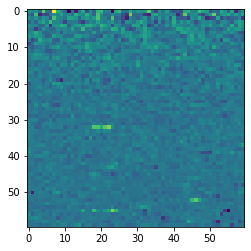

In [48]:
# Plot one of the fluxes.
plt.imshow(flux_2d[3])

## Stuff from Eddie's Notebook

In [ ]:
host_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/hosts/*truth.fits')))
host_coadd= np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/hosts/*coadd.fits')))
host_flux= condition_spectra(host_coadd, host_truth)

In [62]:
snia_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ia/hsiao/*truth.fits')))
snia_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ia/hsiao/*coadd.fits')))
snia_flux  = condition_spectra(snia_coadd, snia_truth)

INFO:spectra.py:282:read_spectra: iotime 0.179 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2021-07-20T10:03:42.431432
INFO:spectra.py:282:read_spectra: iotime 0.166 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2021-07-20T10:03:43.033719
INFO:spectra.py:282:read_spectra: iotime 0.177 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2021-07-20T10:03:43.646984
INFO:spectra.py:282:read_spectra: iotime 0.185 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2021-07-20T10:03:44.275299
INFO:spectra.py:282:read_spectra: iotime 0.173 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2021-07-20T10:03:44.877071
INFO:spectra.py:282:read_spectra: iotime 0.156 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2021-07-20T10:03:45.484597
INFO:spectra.py:282:read_spectra: iotime 0.159 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2021-07-20T10:03:46.168353
INFO:spectra.py:282:read_spectra: iotime 0.164 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2021-07-20T10:03:46.771673


In [63]:
snib_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ib/*/*truth.fits')))
snib_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ib/*/*coadd.fits')))
snib_flux  = condition_spectra(snib_coadd, snib_truth)

INFO:spectra.py:282:read_spectra: iotime 0.192 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-07-20T10:04:56.942805
INFO:spectra.py:282:read_spectra: iotime 0.172 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-07-20T10:04:57.557568
INFO:spectra.py:282:read_spectra: iotime 0.328 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-07-20T10:04:58.348980
INFO:spectra.py:282:read_spectra: iotime 0.181 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-07-20T10:04:58.958873
INFO:spectra.py:282:read_spectra: iotime 0.212 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-07-20T10:04:59.664142
INFO:spectra.py:282:read_spectra: iotime 0.186 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-07-20T10:05:00.263265
INFO:spectra.py:282:read_spectra: iotime 0.189 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-07-20T10:05:00.941545
INFO:spectra.py:282:read_spectra: iotime 0.198 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-07-20T10:05:01.668054


In [64]:
snic_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ic/*/*truth.fits')))
snic_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ic/*/*coadd.fits')))
snic_flux  = condition_spectra(snic_coadd, snic_truth)

INFO:spectra.py:282:read_spectra: iotime 0.179 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-07-20T10:06:11.605510
INFO:spectra.py:282:read_spectra: iotime 0.216 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-07-20T10:06:12.222338
INFO:spectra.py:282:read_spectra: iotime 0.176 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-07-20T10:06:12.828394
INFO:spectra.py:282:read_spectra: iotime 0.191 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-07-20T10:06:13.431239
INFO:spectra.py:282:read_spectra: iotime 0.164 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-07-20T10:06:14.100871
INFO:spectra.py:282:read_spectra: iotime 0.186 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-07-20T10:06:14.719223
INFO:spectra.py:282:read_spectra: iotime 0.165 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-07-20T10:06:15.355101
INFO:spectra.py:282:read_spectra: iotime 0.184 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-07-20T10:06:15.971653


In [65]:
sniin_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iin/*/*truth.fits')))
sniin_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iin/*/*coadd.fits')))
sniin_flux  = condition_spectra(sniin_coadd, sniin_truth)

INFO:spectra.py:282:read_spectra: iotime 0.137 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-07-20T10:07:09.457660
INFO:spectra.py:282:read_spectra: iotime 0.223 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-07-20T10:07:10.195306
INFO:spectra.py:282:read_spectra: iotime 0.145 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-07-20T10:07:10.793130
INFO:spectra.py:282:read_spectra: iotime 0.141 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-07-20T10:07:11.370169
INFO:spectra.py:282:read_spectra: iotime 0.148 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-07-20T10:07:11.952693
INFO:spectra.py:282:read_spectra: iotime 0.136 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-07-20T10:07:12.534991
INFO:spectra.py:282:read_spectra: iotime 0.136 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-07-20T10:07:13.123677
INFO:spectra.py:282:read_spectra: iotime 0.178 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-07-20T10:07:13.722469


In [66]:
sniip_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iip/*/*truth.fits')))
sniip_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iip/*/*coadd.fits')))
sniip_flux  = condition_spectra(sniip_coadd, sniip_truth)

INFO:spectra.py:282:read_spectra: iotime 0.133 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2021-07-20T10:08:20.073862
INFO:spectra.py:282:read_spectra: iotime 0.137 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2021-07-20T10:08:20.687974
INFO:spectra.py:282:read_spectra: iotime 0.149 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2021-07-20T10:08:21.280048
INFO:spectra.py:282:read_spectra: iotime 0.135 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2021-07-20T10:08:21.876711
INFO:spectra.py:282:read_spectra: iotime 0.139 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2021-07-20T10:08:22.452229
INFO:spectra.py:282:read_spectra: iotime 0.138 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2021-07-20T10:08:23.026465
INFO:spectra.py:282:read_spectra: iotime 0.134 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2021-07-20T10:08:23.600304
INFO:spectra.py:282:read_spectra: iotime 0.152 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2021-07-20T10:08:24.166634


### Stack the spectra for image

In [67]:
#host_2d=to_2d(host_flux)
snia_2d=to_2d(snia_flux)
snib_2d=to_2d(snib_flux)
snic_2d=to_2d(snic_flux)
sniin_2d=to_2d(sniin_flux)
sniip_2d=to_2d(sniip_flux)

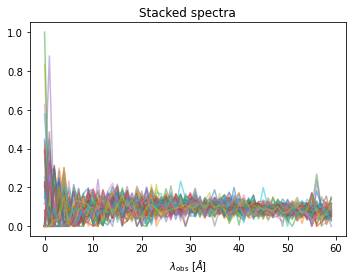

In [68]:
fig,ax= plt.subplots(1,1, figsize=(5,4), tight_layout=True)
ax.plot(snia_2d[3], alpha=0.5)
ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='Stacked spectra')
fig.tight_layout()

In [ ]:
fig.savefig('stacked_spec.png')

### Save the new data

In [69]:
import pickle

#with open(r'/global/homes/k/kenziep/Training/Sim_SpecLens/py/Lensed/host_flux.data', 'wb') as f:
#    pickle.dump(host_2d, f)
    
with open(r'snia_flux_noz.data', 'wb') as f:
    pickle.dump(snia_2d, f) 

with open(r'snib_flux_noz.data', 'wb') as f:
    pickle.dump(snib_2d, f) 

with open(r'snic_flux_noz.data', 'wb') as f:
    pickle.dump(snic_2d, f) 

with open(r'sniin_flux_noz.data', 'wb') as f:
    pickle.dump(sniin_2d, f) 

with open(r'sniip_flux_noz.data', 'wb') as f:
    pickle.dump(sniip_2d, f) 


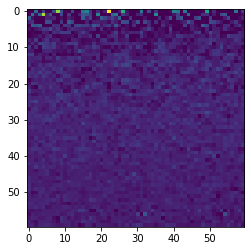

In [70]:
# Plot one of the fluxes.
plt.imshow(snia_2d[3])

## Visual check of all preprocessing steps
Ensure " host_rewave,host_reflux,wavec,fluxc,ivarc " have not been commented out as outputs of condition spectra 

No handles with labels found to put in legend.


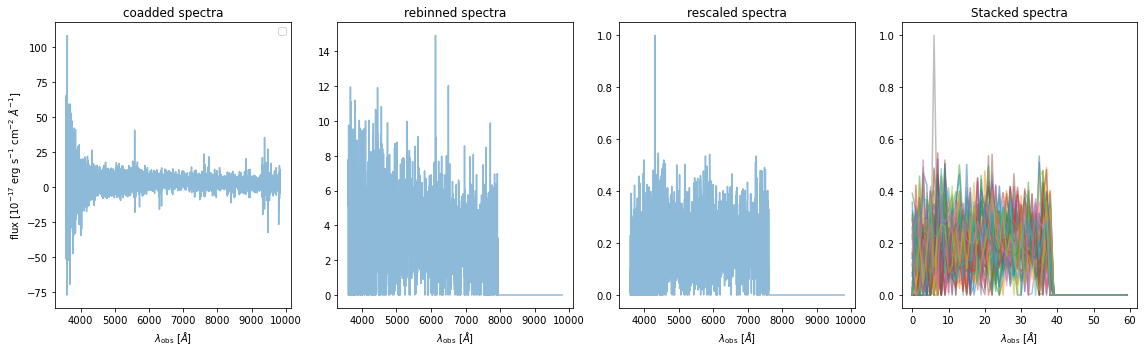

In [13]:
fig, axes = plt.subplots(1,4, figsize=(16,5))

for i in range(6,7):
    
    
    ax = axes[0]
    ax.plot(wavec, fluxc[i], alpha=0.5)

    ax = axes[1]
    ax.plot(host_rewave, host_reflux[i], alpha=0.5)
    
    ax = axes[2]
    ax.plot(host_rewave, host_flux[i], alpha=0.5)
    
    ax = axes[3]
    ax.plot(host_2d[i], alpha=0.5)
    
axes[0].legend(fontsize=10, ncol=2)

axes[0].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
            title='coadded spectra')
axes[1].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='rebinned spectra')
axes[2].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='rescaled spectra')
axes[3].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='Stacked spectra')
fig.tight_layout()